Загружаем все, что может понадобиться

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split 

import pickle
import random
# нормировка
from sklearn.preprocessing import StandardScaler
# поиск лучшей модели
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
# оценки
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score


#  картинки
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
# pip install imbalanced-learn

In [5]:
# балансировка
# pip install imbalanced-learn
# https://imbalanced-learn.org/stable/install.html
import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE

#  работает как на oversampling,  так и на undersampling
# https://imbalanced-learn.org/stable/api.html#module-imblearn.under_sampling._prototype_generation

0.7.0


In [6]:
# определение списка лучших признаков по модели
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [7]:
#  вывод оценок
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

Маршруты и имена файлов

In [8]:
# input
DATASET_PATH = '../training_project_data.csv'
PREP_DATASET_PATH = '../training_project_data_prep.csv'

# output
TRAIN_FULL_PATH = '../training_project_train_full.csv'
TRAIN_PART_PATH = '../training_project_train_part_b.csv'
TEST_PART_PATH = '../training_project_test_part.csv'

SCALER_FILE_PATH = 'scaler.pkl'
PCA_FILE_PATH = 'pca_transform.plk'

Загружаем данные, как уже делали в основном тексте, но без баллансировки

In [9]:
df = pd.read_csv(PREP_DATASET_PATH)
df_base = pd.read_csv(DATASET_PATH)

TARGET_NAME = 'NEXT_MONTH_DEFAULT'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME, 'ID'] + BASE_FEATURE_NAMES).tolist()

NUM_FEATURE_NAMES = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

CAT_FEATURE_NAMES = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

scaler = StandardScaler()

with open(SCALER_FILE_PATH, 'rb') as file:
    scaler = pickle.load( file)
    
df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_s=X.copy()
X_s[NUM_FEATURE_NAMES] = scaler.transform(X[NUM_FEATURE_NAMES])


Делим данные на тренировочные и тестовые для только числовой информации (старые числовые признаки + дамми по категориям)

In [10]:

data_train, data_test, labels_train, labels_test = train_test_split(X_s[SELECTED_FEATURE_NAMES],y, test_size=0.3)

Добавим признаки по РСА (потом сбросим их образующие признаки для исключения мультиколлинеарности)

In [11]:
from sklearn.decomposition import PCA 

In [12]:
#  строим новые признаки (feature engineering :))
pca_trans = PCA(n_components=2)
X_new_PCA= pca_trans.fit_transform(df.loc[:,['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].values)

In [13]:
# не забываем все трансформы сохранять 
with open(PCA_FILE_PATH, 'wb') as file:
    pickle.dump( pca_trans,file)

In [14]:
# добавляем признаки
df['pca1']=X_new_PCA[:,0]
df['pca2']=X_new_PCA[:,1]

In [15]:
len(NUM_FEATURE_NAMES)

14

In [16]:
data_train.shape

(7000, 51)

Начинаем с работы по всем моделям , но без категорийных признаков - только числовые

 Synthetic Minority Over-sampling Technique (SMOTE)
 
 https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [17]:
#https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.SMOTE.html
oversample = SMOTE(k_neighbors=3)
data_bal_train, labels_bal_train = oversample.fit_resample(data_train, labels_train)
print('до баллансировки :',np.sum(labels_train))
print('после баллансировки :',np.sum(labels_bal_train))

до баллансировки : 1545
после баллансировки : 5455


Логистическая регрессия - Максимизация правдоподобия

In [18]:
data_train = data_bal_train
labels_train = labels_bal_train
Labels_train1 = (labels_train == 1)
Labels_test1 = (labels_test==1)


LRC = LogisticRegression()
LRC.fit(data_train, labels_train.astype(int))

# Test 
y_train_pred = LRC.predict(data_train)
y_test_pred= LRC.predict(data_test)

In [19]:
LRC = np.mean(np.abs(y_test_pred-labels_test.astype(int)))*100
print(f'ошибка LRC = {LRC:4.4f}%')

ошибка LRC = 21.0667%


In [20]:


get_classification_report(labels_train.astype(int), y_train_pred, labels_test.astype(int), y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.88      0.77      5455
           1       0.83      0.60      0.70      5455

    accuracy                           0.74     10910
   macro avg       0.76      0.74      0.73     10910
weighted avg       0.76      0.74      0.73     10910

TEST

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2350
           1       0.51      0.52      0.52       650

    accuracy                           0.79      3000
   macro avg       0.69      0.69      0.69      3000
weighted avg       0.79      0.79      0.79      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2031  319
1                    313  337


SVM - максимизация зазора

In [21]:
from sklearn import svm

cSVM = svm.SVC()
cSVM.fit(data_train, labels_train.astype(int))

# Test 
predicteds = cSVM.predict(data_test)
# Test 
y_train_pred = cSVM.predict(data_train)
y_test_pred= cSVM.predict(data_test)

In [22]:
SVM = np.mean(np.abs(y_test_pred-labels_test.astype(int)))*100
print(f'ошибка SVM = {SVM:4.4f}%')

ошибка SVM = 23.1000%


In [23]:

get_classification_report(labels_train.astype(int), y_train_pred, labels_test.astype(int), y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.84      0.76      5455
           1       0.80      0.61      0.69      5455

    accuracy                           0.73     10910
   macro avg       0.74      0.73      0.72     10910
weighted avg       0.74      0.73      0.72     10910

TEST

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2350
           1       0.47      0.55      0.51       650

    accuracy                           0.77      3000
   macro avg       0.67      0.69      0.68      3000
weighted avg       0.78      0.77      0.77      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1952  398
1                    295  355


In [24]:
from sklearn.datasets import load_iris

iris= load_iris()

In [25]:
X_d=iris.data

# для разных задач увидим разные ответы:
# iris.target==2 - линейной разделимости нет - есть несколько ошибок
# iris.target==0 - линейно разделим - нет ошибок
# iris.target==1 - линейно разделим при ядре rbf- нет ошибок (kernel = 'rbf')
y_d=(iris.target==2).astype(int)

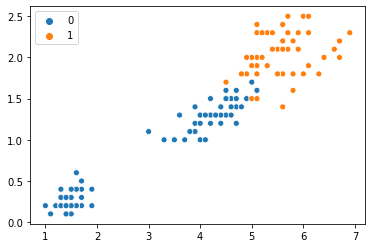

In [26]:
sns.scatterplot(x=X_d[:,2],y=X_d[:,3],hue = y_d)
plt.show()

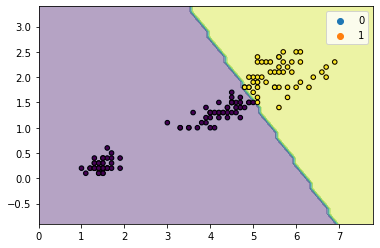

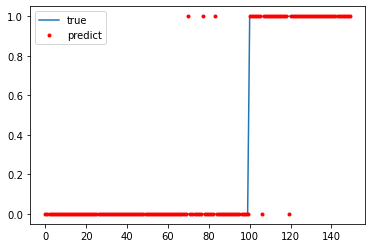

In [27]:
svci = svm.SVC(kernel = 'linear', C=0.1)
svci.fit(X_d[:,2:], y_d)
y_r = svci.predict(X_d[:,2:])
sns.scatterplot(x=X_d[:,2],y=X_d[:,3],hue = y_r)

x_min, x_max = X_d[:, 2].min() - 1, X_d[:, 2].max() + 1
y_min, y_max = X_d[:, 3].min() - 1, X_d[:, 3].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = svci.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_d[:, 2], X_d[:, 3], c=y_r,s=20, edgecolor='k')

plt.show()


plt.plot(y_d, label='true')
plt.plot(y_r,'.r',label='predict')
plt.legend()
plt.show()


In [28]:
print('параметры границы',svci.coef_, svci.coef0)

параметры границы [[1.19016375 0.95213016]] 0.0


In [29]:
from sklearn.model_selection import GridSearchCV

SVM + ядра (линейное и радиально-базисное)

In [30]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC(kernel = 'rbf', C=10)
svc.fit(data_train, labels_train.astype(int))

# Test 
predicteds_r = svc.predict(data_test)
# Test 
y_train_pred_r = svc.predict(data_train)
y_test_pred_r= svc.predict(data_test)
print('ошибка SVM = ',np.mean(np.abs(y_test_pred_r-labels_test.astype(int)))*100,'%')
#clf = GridSearchCV(svc, parameters, scoring ='f1_micro',)
#clf.fit(X_s, y)
#GridSearchCV(estimator=SVC(),     param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

ошибка SVM =  22.066666666666666 %


In [31]:
# pip install catboost

In [32]:
from sklearn.neighbors import KNeighborsClassifier
import catboost as catb

In [33]:
model_knn = KNeighborsClassifier()
model_knn.fit(data_train, labels_train.astype(int))

y_train_pred = model_knn.predict(data_train)
y_test_pred = model_knn.predict(data_test)
print('ошибка knn = ',np.mean(np.abs(y_test_pred-labels_test.astype(int)))*100,'%')
get_classification_report(labels_train.astype(int), y_train_pred, labels_test.astype(int), y_test_pred)

ошибка knn =  29.166666666666668 %
TRAIN

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      5455
           1       0.83      0.87      0.85      5455

    accuracy                           0.84     10910
   macro avg       0.84      0.84      0.84     10910
weighted avg       0.84      0.84      0.84     10910

TEST

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      2350
           1       0.38      0.55      0.45       650

    accuracy                           0.71      3000
   macro avg       0.62      0.65      0.63      3000
weighted avg       0.76      0.71      0.73      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1766  584
1                    291  359


In [34]:
catb_m = catb.CatBoostClassifier(silent=True)
catb_m.fit(data_train, labels_train)

y_train_pred = catb_m.predict(data_train)
y_test_pred = catb_m.predict(data_test)
print('ошибка cat = ',np.mean(np.abs(y_test_pred-labels_test.astype(int)))*100,'%')
get_classification_report(labels_train, y_train_pred, labels_test, y_test_pred)

ошибка cat =  19.833333333333332 %
TRAIN

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5455
           1       0.93      0.87      0.90      5455

    accuracy                           0.91     10910
   macro avg       0.91      0.91      0.90     10910
weighted avg       0.91      0.91      0.90     10910

TEST

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      2350
           1       0.55      0.47      0.51       650

    accuracy                           0.80      3000
   macro avg       0.70      0.68      0.69      3000
weighted avg       0.79      0.80      0.80      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2101  249
1                    346  304


In [35]:
# без балансировки
X_c = df[SELECTED_FEATURE_NAMES+CAT_FEATURE_NAMES+['pca1','pca2']]
y_c = df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X_c,y_c, test_size=0.3)

In [36]:
# баланс по SMOTE
X_c = df[SELECTED_FEATURE_NAMES+CAT_FEATURE_NAMES+['pca1','pca2']]
y_c = df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X_c,y_c, test_size=0.3)

print('до баллансировки :',np.sum(y_train))
X_train, y_train = oversample.fit_resample(X_train, y_train)

print('после баллансировки :',np.sum(y_train))



до баллансировки : 1533
после баллансировки : 5467


In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10934 entries, 0 to 10933
Data columns (total 62 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   LIMIT_BAL    10934 non-null  float64 
 1   AGE          10934 non-null  float64 
 2   BILL_AMT1    10934 non-null  float64 
 3   BILL_AMT2    10934 non-null  float64 
 4   BILL_AMT3    10934 non-null  float64 
 5   BILL_AMT4    10934 non-null  float64 
 6   BILL_AMT5    10934 non-null  float64 
 7   BILL_AMT6    10934 non-null  float64 
 8   PAY_AMT1     10934 non-null  float64 
 9   PAY_AMT2     10934 non-null  float64 
 10  PAY_AMT3     10934 non-null  float64 
 11  PAY_AMT4     10934 non-null  float64 
 12  PAY_AMT5     10934 non-null  float64 
 13  PAY_AMT6     10934 non-null  float64 
 14  IS_MALE      10934 non-null  int64   
 15  EDUCATION_1  10934 non-null  int64   
 16  EDUCATION_2  10934 non-null  int64   
 17  EDUCATION_3  10934 non-null  int64   
 18  EDUCATION_4  10934 non-nul

In [38]:
X_train.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,pca1,pca2
0,1.166824,-0.151823,-0.588414,-0.582282,-0.335608,-0.513340,-0.297057,-0.530576,0.168711,0.865147,...,1,1,-1,-1,-1,0,-1,-1,-1.160433,-0.116707
1,-1.138879,-1.456895,-0.437911,-0.515421,-0.601378,-0.573254,-0.542971,-0.537094,-0.136413,-0.223728,...,2,2,0,0,2,2,2,2,-1.310681,0.058213
2,1.474251,2.023296,1.080025,-0.525155,0.333853,0.365071,0.513833,-0.194333,0.413217,2.933056,...,1,2,0,-1,-1,0,0,-1,0.640536,0.219673
3,-1.138879,-0.586847,-0.667770,-0.666050,-0.675879,-0.664248,-0.654600,-0.653431,-0.273854,-0.251404,...,2,1,-1,-1,-1,-1,-1,-1,-1.625593,-0.014837
4,-0.754595,-0.478091,0.222736,0.273991,0.324846,0.347533,-0.169521,-0.149142,-0.156754,-0.132399,...,3,2,2,0,0,0,0,0,0.350110,0.382207


In [39]:
X_train.tail()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,pca1,pca2
10929,-1.158723,1.423355,-0.503855,-0.487848,-0.464750,-0.443689,-0.406395,-0.441654,-0.249390,-0.199221,...,3,1,0,0,0,0,0,0,-1.121538,-0.071559
10930,2.038640,0.963240,4.617316,4.855296,4.983217,4.840389,3.494674,2.858198,0.602386,0.414985,...,NaN,1,0,0,0,0,0,0,10.483761,1.545938
10931,0.090829,-1.236801,1.635227,1.750228,1.834743,2.030371,2.311779,2.280101,0.161958,0.031072,...,NaN,NaN,0,0,0,0,0,2,4.834454,-0.617864
10932,1.845764,1.013860,-0.685505,-0.684617,-0.678997,-0.669797,-0.658558,-0.653369,-0.364226,-0.260984,...,3,1,-1,-1,-1,-1,-1,-1,-1.645508,-0.030050
10933,-0.908309,0.784105,-0.049786,-0.003665,0.012245,-0.147251,-0.355313,-0.334957,-0.223014,-0.182088,...,2,2,0,0,0,0,0,0,-0.357572,0.332158


In [40]:
from sklearn.impute import KNNImputer, SimpleImputer
imp_s=SimpleImputer()
# очень примитивное заполнение пробела
for s_col in CAT_FEATURE_NAMES:
    X_train.loc[X_train[s_col].isna(),[s_col]] = X_train[s_col][0]


In [41]:
list_feature = X_train.columns.tolist()
ind_to_del = []
k=0
for x in list_feature:
    if x in ['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']:
        ind_to_del.append( k)
    k += 1    
ind_to_del        

[2, 3, 4, 5, 6, 7]

In [42]:
catb_m = catb.CatBoostClassifier(silent=True,  cat_features=CAT_FEATURE_NAMES)
catb_m.fit(X_train, y_train)

y_train_pred = catb_m.predict(X_train)
y_test_pred = catb_m.predict(X_test)
print('ошибка cat = ',np.mean(np.abs(y_test_pred-y_test.astype(int)))*100,'%')
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

ошибка cat =  18.73333333333333 %
TRAIN

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      5467
           1       0.94      0.87      0.90      5467

    accuracy                           0.91     10934
   macro avg       0.91      0.91      0.91     10934
weighted avg       0.91      0.91      0.91     10934

TEST

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      2338
           1       0.60      0.47      0.53       662

    accuracy                           0.81      3000
   macro avg       0.73      0.69      0.70      3000
weighted avg       0.80      0.81      0.80      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2127  211
1                    351  311


In [43]:
from catboost import Pool,cv

In [44]:
c_dataset = Pool(data=X_c,
                  label=y_c,
                  cat_features=CAT_FEATURE_NAMES)


params = {"iterations": 150,
          
          "max_depth":3,
          "eval_metric":"F1",
          "l2_leaf_reg":10.0,
          "loss_function": "Logloss",
          "colsample_bylevel":0.5,
          "ignored_features":ind_to_del,
          "verbose": False}
scores = cv(c_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [45]:
c_dataset = Pool(data=X_c,
                  label=y_c,
                  cat_features=CAT_FEATURE_NAMES)


params = {"iterations": 150,
          "max_depth":10,
          "class_weights":[1,3.5],
          "eval_metric":"F1",
          "l2_leaf_reg":10.0,
          "loss_function": "Logloss",
          "colsample_bylevel":0.5,
          "ignored_features":ind_to_del,
          "verbose": False}
scores = cv(c_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [46]:
c_dataset = Pool(data=X_c,
                  label=y_c,
                  cat_features=CAT_FEATURE_NAMES)


params = {"iterations": 50,
          "max_depth":16,
          "eval_metric":"F1",
          "l2_leaf_reg":3.0,
          "loss_function": "Logloss",
          "ignored_features":[],
          "verbose": False}
scores = cv(c_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Подбор в сетке

In [47]:
catb_model_grid = catb.CatBoostClassifier(cat_features=CAT_FEATURE_NAMES,iterations=150,eval_metric="F1",loss_function="Logloss",colsample_bylevel=0.5,
          ignored_features=ind_to_del,class_weights=[1,3.5],verbose=False)
grid = {'depth': [2,3,4, 5, 10],
        'l2_leaf_reg': [10, 3]}
grid_search_result = catb_model_grid.grid_search(grid, 
                                       X=X_c, 
                                       y=y_c, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6737419945
bestIteration = 148

0:	loss: 0.6737420	best: 0.6737420 (0)	total: 3.03s	remaining: 27.3s

bestTest = 0.6676524954
bestIteration = 134

1:	loss: 0.6676525	best: 0.6737420 (0)	total: 4.84s	remaining: 19.4s

bestTest = 0.6639912441
bestIteration = 122

2:	loss: 0.6639912	best: 0.6737420 (0)	total: 6.72s	remaining: 15.7s

bestTest = 0.6708279787
bestIteration = 129

3:	loss: 0.6708280	best: 0.6737420 (0)	total: 8.13s	remaining: 12.2s

bestTest = 0.673823582
bestIteration = 144

4:	loss: 0.6738236	best: 0.6738236 (4)	total: 9.84s	remaining: 9.84s

bestTest = 0.6761718054
bestIteration = 149

5:	loss: 0.6761718	best: 0.6761718 (5)	total: 12.1s	remaining: 8.08s

bestTest = 0.6866619619
bestIteration = 125

6:	loss: 0.6866620	best: 0.6866620 (6)	total: 14.6s	remaining: 6.27s

bestTest = 0.6905388801
bestIteration = 141

7:	loss: 0.6905389	best: 0.6905389 (7)	total: 17.2s	remaining: 4.29s

bestTest = 0.6733668342
bestIteration = 105

8:	loss: 0.6733668	best: 0.6905389 

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif,chi2
from sklearn.feature_selection import SelectFromModel, SelectKBest

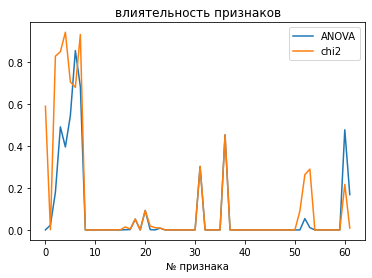

In [49]:
rez_c = chi2(np.abs(X_c),y_c)
rez_f = f_classif(X_c,y_c)

plt.plot(rez_f[1], label= 'ANOVA')
plt.plot(rez_c[1],label='chi2')
plt.title('влиятельность признаков')
plt.xlabel('№ признака')
plt.legend()
plt.show()



In [ ]:
selector = SelectKBest(f_classif, k=4)
selector.fit(X_c, y_c)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(np.arange(X_c.shape[-1]) - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)')
plt.show()

In [51]:
ind_select =  np.where(selector.pvalues_>0.01)[0]
print(X_c.columns[ind_select])

Index(['AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'EDUCATION_4', 'EDUCATION_6', 'PAY_2_1', 'PAY_3_1',
       'EDUCATION', 'MARRIAGE', 'pca1', 'pca2'],
      dtype='object')


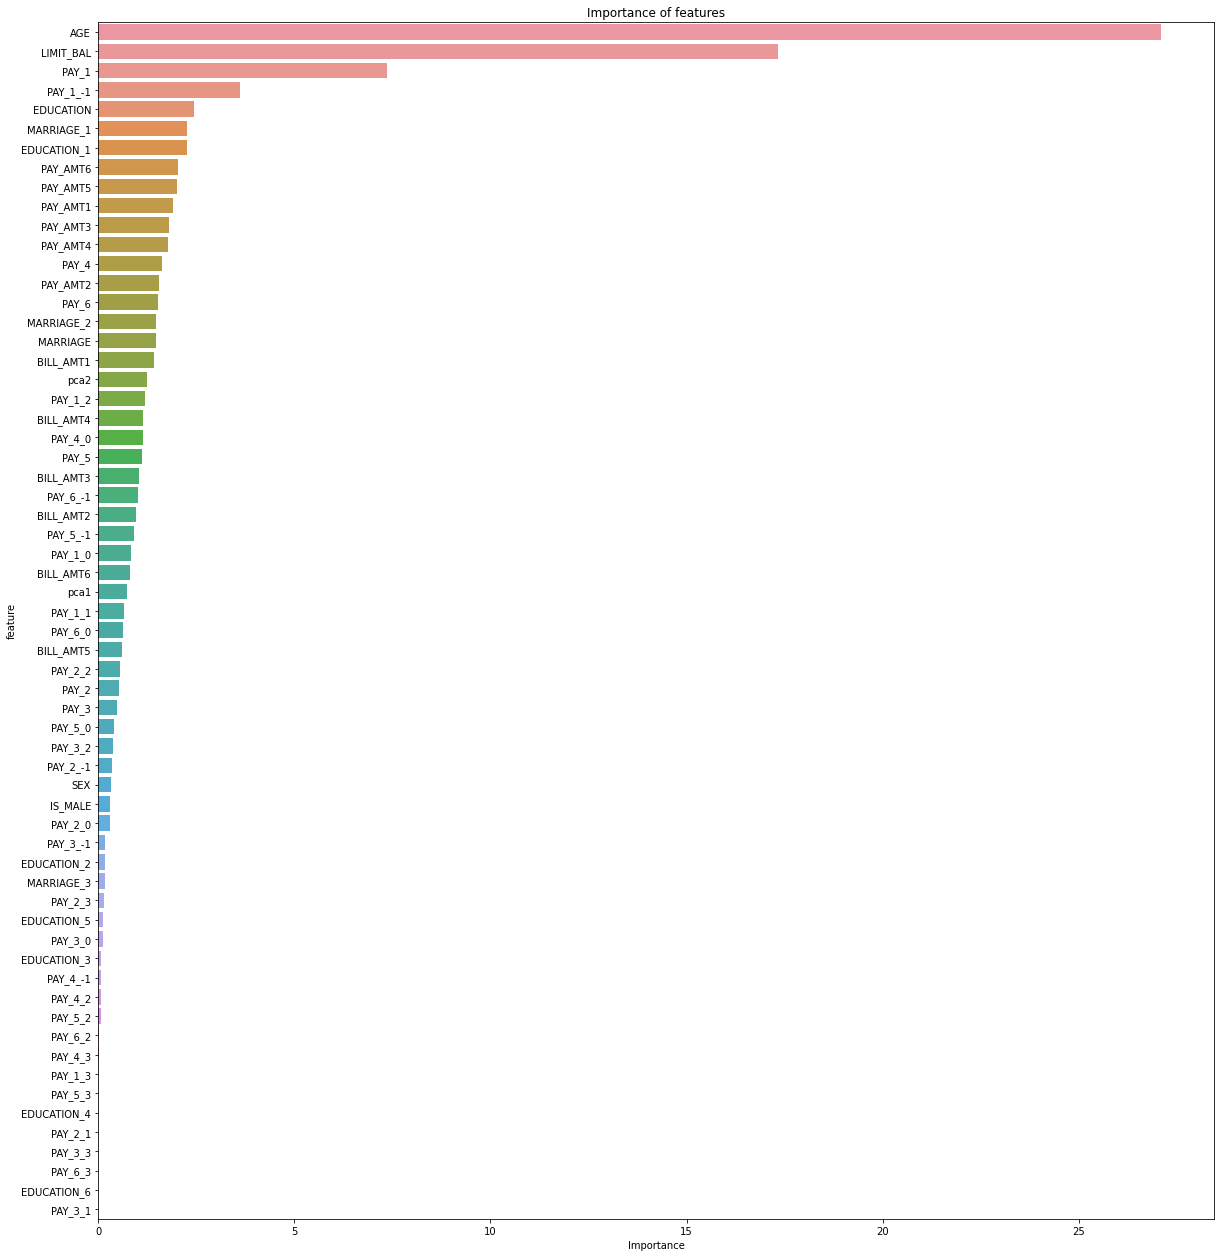

['AGE', 'LIMIT_BAL', 'PAY_1', 'PAY_1_-1', 'EDUCATION', 'MARRIAGE_1', 'EDUCATION_1', 'PAY_AMT6', 'PAY_AMT5', 'PAY_AMT1', 'PAY_AMT3', 'PAY_AMT4', 'PAY_4', 'PAY_AMT2', 'PAY_6']


In [52]:
important_features_top = show_feature_importances(X_c.columns, catb_m.feature_importances_, get_top=15)
print(important_features_top)

In [55]:
CAT_FEATURE_NAMES_new = ['PAY_1','EDUCATION','PAY_6', 'PAY_4']
X_train_new, X_test_new, y_train, y_test = train_test_split(X_c[important_features_top],y_c, test_size=0.3)

In [56]:

train_dataset = Pool(data=X_train_new,
                  label=y_train,
                  cat_features=CAT_FEATURE_NAMES_new)
val_dataset = Pool(data=X_test_new,
                    label=y_test,
                    cat_features=CAT_FEATURE_NAMES_new)

In [57]:
catb_model = catb.CatBoostClassifier(cat_features=CAT_FEATURE_NAMES_new,iterations=150,eval_metric="F1",loss_function="Logloss",colsample_bylevel=0.5,
          ignored_features=ind_to_del,depth = 4, l2_leaf_reg = 10,class_weights=[1,3.5],verbose=False)
catb_model.fit(train_dataset)

In [58]:
print('ошибка cat = ',np.mean(np.abs(catb_model.predict(val_dataset)-y_test.astype(int)))*100,'%')
get_classification_report(y_train, catb_model.predict(train_dataset), y_test, catb_model.predict(val_dataset))

ошибка cat =  29.933333333333334 %
TRAIN

              precision    recall  f1-score   support

           0       0.87      0.73      0.79      5486
           1       0.38      0.61      0.47      1514

    accuracy                           0.70      7000
   macro avg       0.63      0.67      0.63      7000
weighted avg       0.76      0.70      0.72      7000

TEST

              precision    recall  f1-score   support

           0       0.86      0.73      0.79      2319
           1       0.40      0.60      0.48       681

    accuracy                           0.70      3000
   macro avg       0.63      0.67      0.63      3000
weighted avg       0.76      0.70      0.72      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1692  627
1                    271  410


In [ ]:
https://konstantinklepikov.github.io/2019/10/28/data-preprocessing-category-encoders.html